In [10]:
import numpy as np
import matplotlib.pyplot as plt

# np.set_printoptions(precision=5)
import polars as pl
import arviz as az
import pymc as pm
import aleatory as al

In [11]:
rng = np.random.default_rng(42)


In [12]:
X = rng.standard_normal((5, 5))

mat = X.T @ X
mat

array([[ 3.3344224 ,  0.00963006,  1.29650589,  0.57349885,  1.049512  ],
       [ 0.00963006,  2.30251259, -1.95558098,  0.32559182,  2.55686795],
       [ 1.29650589, -1.95558098,  3.08160959, -0.24565571, -1.63929328],
       [ 0.57349885,  0.32559182, -0.24565571,  2.9511713 , -1.27141509],
       [ 1.049512  ,  2.55686795, -1.63929328, -1.27141509,  4.93874455]])

In [13]:
np.linalg.inv(mat)

array([[ 7.84438443e-01,  4.63616701e-01, -4.48384959e-01,
        -5.40160666e-01, -6.94607117e-01],
       [ 4.63616701e-01,  3.60721302e+00,  9.40885274e-01,
        -1.26218773e+00, -1.97866405e+00],
       [-4.48384959e-01,  9.40885274e-01,  1.11493368e+00,
         7.50942259e-02, -2.42061387e-03],
       [-5.40160666e-01, -1.26218773e+00,  7.50942259e-02,
         1.04717109e+00,  1.06274844e+00],
       [-6.94607117e-01, -1.97866405e+00, -2.42061387e-03,
         1.06274844e+00,  1.64726226e+00]])

In [14]:
mat @ np.linalg.inv(mat)

array([[ 1.00000000e+00,  6.32751543e-17,  7.11223859e-17,
        -2.83647591e-16, -1.74703982e-16],
       [ 7.18014023e-16,  1.00000000e+00, -2.05089525e-18,
        -5.26707534e-16, -4.26785971e-16],
       [-2.25655718e-16,  8.76405113e-16,  1.00000000e+00,
        -2.20136069e-16, -2.43593233e-16],
       [-3.51927064e-17, -5.90839458e-16,  2.31690112e-17,
         1.00000000e+00,  4.75266669e-16],
       [ 2.22044605e-16, -3.55271368e-15, -4.44089210e-16,
         0.00000000e+00,  1.00000000e+00]])

In [15]:
X.T.dot(X)

array([[ 3.3344224 ,  0.00963006,  1.29650589,  0.57349885,  1.049512  ],
       [ 0.00963006,  2.30251259, -1.95558098,  0.32559182,  2.55686795],
       [ 1.29650589, -1.95558098,  3.08160959, -0.24565571, -1.63929328],
       [ 0.57349885,  0.32559182, -0.24565571,  2.9511713 , -1.27141509],
       [ 1.049512  ,  2.55686795, -1.63929328, -1.27141509,  4.93874455]])

In [16]:
import random

In [17]:
position = 0
walk = [position]
nsteps = 1_000


In [18]:
for _ in range(nsteps):
    step = 1 if random.randint(0, 1) else -1
    position += step
    walk.append(position)

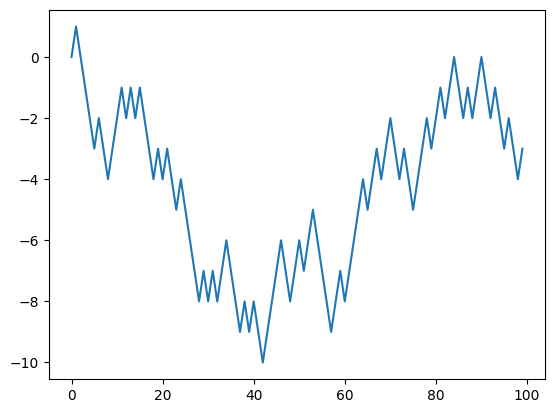

In [19]:
plt.plot(walk[:100])

In [20]:
nsteps = 1_000
rng = np.random.default_rng(seed=12345)  # fresh seed
draws = rng.integers(0, 2, size=nsteps)

steps = np.where(draws == 0, 1, -1)
walk = steps.cumsum()
# from here we can begin to extract stats like the min and max value along the walks trajectory


In [21]:
walk.min()

np.int64(-8)

In [22]:
walk.max()

np.int64(50)

- A more complicated statistic is the _first crossing time_, the step at which the random walk reaches a particular value. Here we might want to know how long it took the random walk to get at least 10 steps away from the origin in either direction. `np.abs(walk) >= 10` gives us a boolean array indicating where the walk has reached or exceeded 10, but we want the index of the _first_ 10 or -10. Turns out, we can compute this using argmax, which returns the first index of the maximum value in the boolean array (True is the maximum value):


In [23]:
(np.abs(walk) >= 10).argmax()

np.int64(155)

- Note that using `argmax` here isnt always efficient because it always makes a full scan of the array. In this special case, once a `True` is observed we know it to be the maximum value.


In [24]:
nwalks = 5_000
n_steps = 1_000
draws = rng.integers(0, 2, size=(nwalks, n_steps))  # 0 or 1
steps = np.where(draws > 0, 1, -1)
walks = steps.cumsum(axis=1)
walks

array([[  1,   2,   3, ...,  22,  23,  22],
       [  1,   0,  -1, ..., -50, -49, -48],
       [  1,   2,   3, ...,  50,  49,  48],
       ...,
       [ -1,  -2,  -1, ..., -10,  -9, -10],
       [ -1,  -2,  -3, ...,   8,   9,   8],
       [ -1,   0,   1, ...,  -4,  -3,  -2]])

In [25]:
walks.max()

np.int64(114)

In [26]:
walks.min()

np.int64(-120)

Lets compute the minimum crossing time to |30|. Slightly tricky bc not all 5,000 of them reach 30. We can check this using the `any` method.


In [27]:
hits30 = (np.abs(walks) >= 30).any(axis=1)
hits30

array([False,  True,  True, ...,  True, False,  True])

In [28]:
hits30.sum()  # number that hit |30|

np.int64(3395)

Use this boolean array to select the rows of walks that actually cross the |30| level, and call `argmax` across axis 1 to get the crossing times:


In [29]:
crossing_times = (np.abs(walks[hits30]) >= 30).argmax(axis=1)
crossing_times

array([201, 491, 283, ..., 219, 259, 541])

In [30]:
# compute teh avg minimum crossing time
crossing_times.mean()

np.float64(500.5699558173785)

In [32]:
draws = 0.25 * rng.standard_normal((nwalks, n_steps))
draws

array([[ 3.93412554e-01,  1.91760393e-01, -2.68838712e-01, ...,
         6.49571736e-02,  2.30678783e-01, -1.46605736e-01],
       [ 7.50281084e-02, -2.31642667e-01,  3.48210776e-01, ...,
         9.08536095e-02, -7.88924500e-02, -2.77116166e-02],
       [-4.53416129e-04,  9.38041843e-02, -1.37977032e-01, ...,
        -2.30077034e-01,  3.36572365e-01,  1.63960481e-01],
       ...,
       [-8.95627722e-02,  1.51582795e-01, -1.67003345e-01, ...,
        -9.42934639e-02, -5.24502460e-01,  3.74770605e-01],
       [ 5.23416023e-01, -4.15522086e-01, -9.50569378e-02, ...,
         3.61357438e-01,  1.90006203e-02,  1.18884549e-02],
       [ 1.27026552e-01,  3.03780377e-01, -2.15250834e-01, ...,
        -2.25211815e-01, -2.47241170e-01,  1.94010562e-01]])

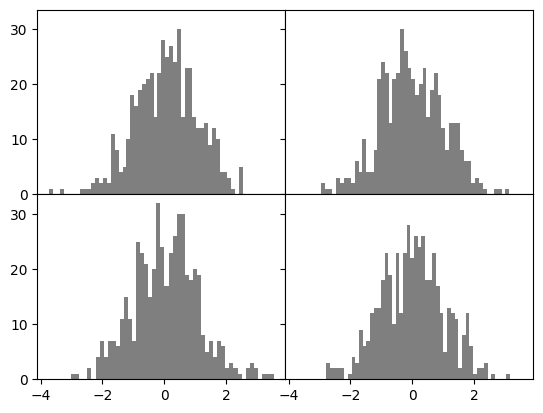

In [37]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        axes[i, j].hist(
            rng.standard_normal(500), bins=50, color="black", alpha=0.5
        )
fig.subplots_adjust(wspace=0, hspace=0)

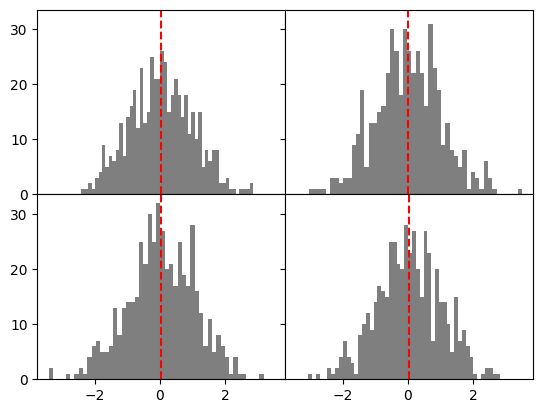

In [39]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        data = rng.standard_normal(500)
        axes[i, j].hist(data, bins=50, color="black", alpha=0.5)
        axes[i, j].axvline(data.mean(), color="red", linestyle="--")
        # plt.axvline(data.mean())
fig.subplots_adjust(wspace=0, hspace=0)

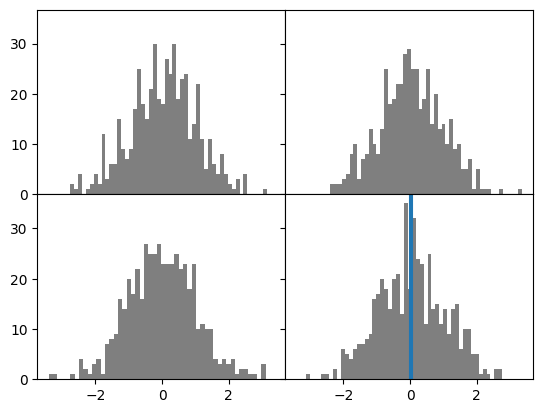

In [40]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        data = rng.standard_normal(500)
        axes[i, j].hist(data, bins=50, color="black", alpha=0.5)
        # axes[i, j].axvline(data.mean(), color="red", linestyle="--")
        plt.axvline(data.mean())
fig.subplots_adjust(wspace=0, hspace=0)